In [1]:
#import libraries
import pandas as pd
import numpy as np
import math
from math import sqrt
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model #for plotting  model charts
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
from keras import regularizers
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import ExtraTreesRegressor
import seaborn as sns
from datetime import datetime

In [2]:
#load data
train_data = pd.read_pickle("EDA_train_median.pkl")
test_data = pd.read_pickle("EDA_test_median.pkl")

In [3]:
#split data
y = train_data['windmill_generated_power(kW/h)']
train_data.drop(['windmill_generated_power(kW/h)'], axis=1, inplace = True)

In [4]:
#split dataset 
X_train, X_test, y_train, y_test = train_test_split(train_data, y, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((21051, 33), (21051,), (7018, 33), (7018,))

### SVR USING STANDARD SCALER

In [5]:
# declare the steps in our pipeline
pipe = Pipeline([('StandardScaler', StandardScaler()),('SVM',SVR(kernel='rbf'))])

In [6]:
# fit the pipeline to our training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('StandardScaler', StandardScaler()), ('SVM', SVR())])

In [7]:
pipe.score(X_train,y_train)

0.6060328443789926

In [8]:
pipe.score(X_test,y_test)

0.5347148125218611

In [9]:
#SVR Model Evaluation
prediction = pipe.predict(X_test)

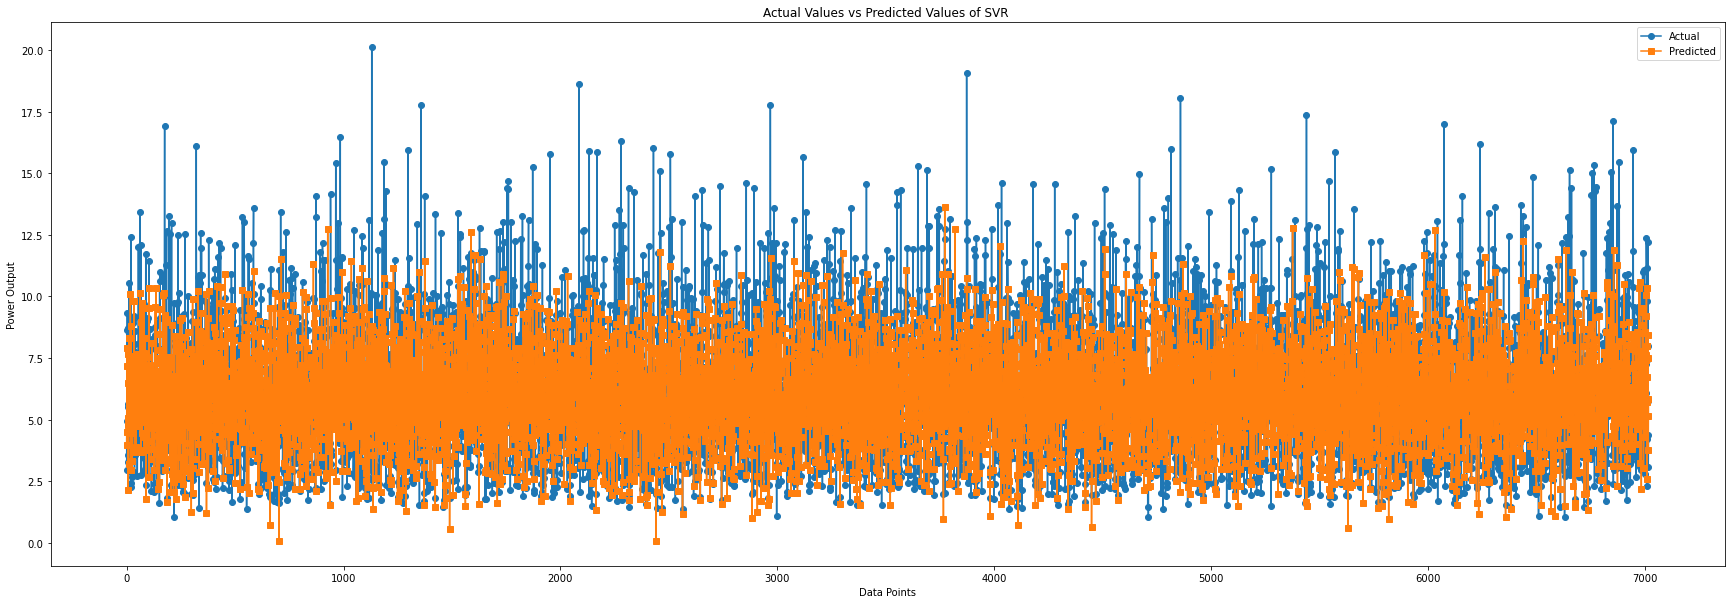

In [10]:
# Sort the actual and predicted values based on the data points
sorted_indices = range(len(y_test))
y_test_sorted = y_test.iloc[sorted_indices]
y_pred_sorted = prediction[sorted_indices]

# Line plot with markers for actual and predicted values
plt.rcParams['figure.figsize'] = [30, 10]
plt.plot(sorted_indices, y_test_sorted, marker='o', label='Actual')
plt.plot(sorted_indices, y_pred_sorted, marker='s', label='Predicted')
plt.xlabel('Data Points')
plt.ylabel('Power Output')
plt.title('Actual Values vs Predicted Values of SVR ')
plt.legend()
plt.show()

### Extra Trees Regressor for feature selection

In [11]:
# Feature selection by ExtraTreesRegressor(model based). 
# ExtraTreesRegressor helps us find the features which are most important.
reg= ExtraTreesRegressor()
reg.fit(X_train,y_train)

ExtraTreesRegressor()

In [12]:
#print each feature importance
reg_importance  = reg.feature_importances_

In [13]:
# Use ExtraTreesRegressor to extract the best 10 features
best_feature_indices = np.argsort(reg_importance)[::-1][:10]
best_features = train_data.columns[best_feature_indices]

In [14]:
# Print the best 10 features
print('Best 10 Features:', best_features)

Best 10 Features: Index(['blades_angle(°)', 'month', 'rotor_torque(N-m)',
       'engine_temperature(°C)', 'day', 'time_hour', 'wind_direction(°)',
       'wind_speed(m/s)', 'dayofweek', 'blade_breadth(m)'],
      dtype='object')


In [15]:
# Train the SVR model with the best features
tree_reg_best = Pipeline(steps=[('StandardScaler', StandardScaler()),('SVM',SVR(kernel = 'rbf'))])
tree_reg_best.fit(X_train.iloc[:, best_feature_indices], y_train)

Pipeline(steps=[('StandardScaler', StandardScaler()), ('SVM', SVR())])

In [16]:
# declare the steps in our pipeline
# Evaluate the performance of the SVR on the testing data
prediction_featureselection = tree_reg_best.predict(X_test.iloc[:, best_feature_indices])

In [17]:
tree_reg_best.score(X_train.iloc[:, best_feature_indices],y_train)

0.695095730463914

In [18]:
tree_reg_best.score(X_test.iloc[:, best_feature_indices],y_test)

0.6773899902590644

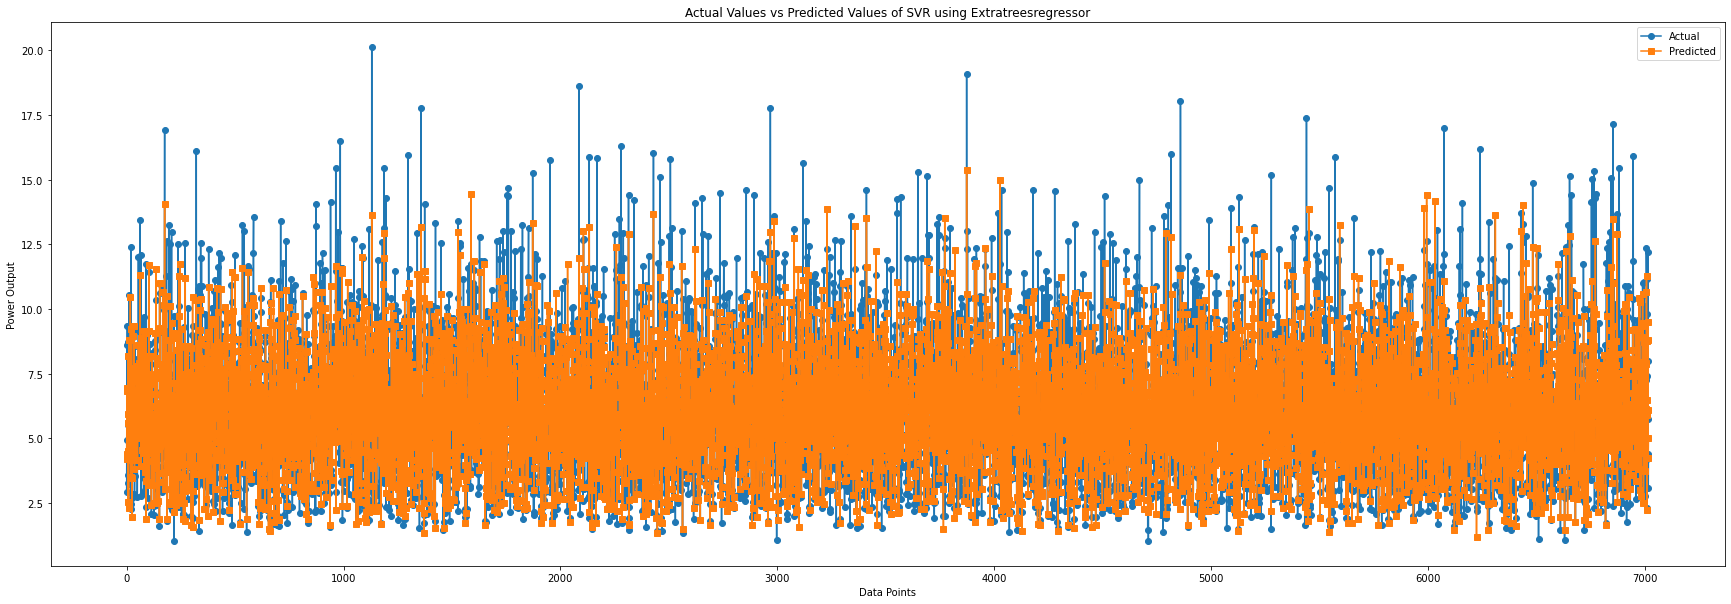

In [19]:
# Sort the actual and predicted values based on the data points
sorted_indices = range(len(y_test))
y_test_sorted = y_test.iloc[sorted_indices]
y_pred_sorted = prediction_featureselection[sorted_indices]

# Line plot with markers for actual and predicted values
plt.rcParams['figure.figsize'] = [30, 10]
plt.plot(sorted_indices, y_test_sorted, marker='o', label='Actual')
plt.plot(sorted_indices, y_pred_sorted, marker='s', label='Predicted')
plt.xlabel('Data Points')
plt.ylabel('Power Output')
plt.title('Actual Values vs Predicted Values of SVR using Extratreesregressor')
plt.legend()
plt.show()

### Hyperparameter Tuning

In [20]:
# Define the hyperparameter grid
param_grid = {'SVM__C': [0.1, 1, 10],
    'SVM__kernel': ['linear', 'rbf']}
 
tuning_model = GridSearchCV(tree_reg_best, param_grid=param_grid, cv=5)

In [21]:
# function for calculating how much time take for hyperparameter tuning

def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        print(thour,":",tmin,':',round(tsec,2))

In [22]:
start_time=timer(None)

tuning_model.fit(X_train,y_train)

timer(start_time)

0.0 : 45.0 : 22.93


In [24]:
# best hyperparameters 
tuning_model.best_params_

{'SVM__C': 10, 'SVM__kernel': 'rbf'}

In [36]:
#best model score
tuning_model.best_score_

0.5552713559526892

In [46]:
#Training Decision Tree With Best Hyperparameters
tuned_hyper_model= Pipeline([
   ('StandardScaler', StandardScaler()),('SVM',SVR(kernel='rbf', C = 10)) # Added to the original code
])
# fitting model
tuned_hyper_model.fit(X_train,y_train)

Pipeline(steps=[('StandardScaler', StandardScaler()), ('SVM', SVR(C=10))])

In [47]:
# prediction 
tuned_pred = tuned_hyper_model.predict(X_test)

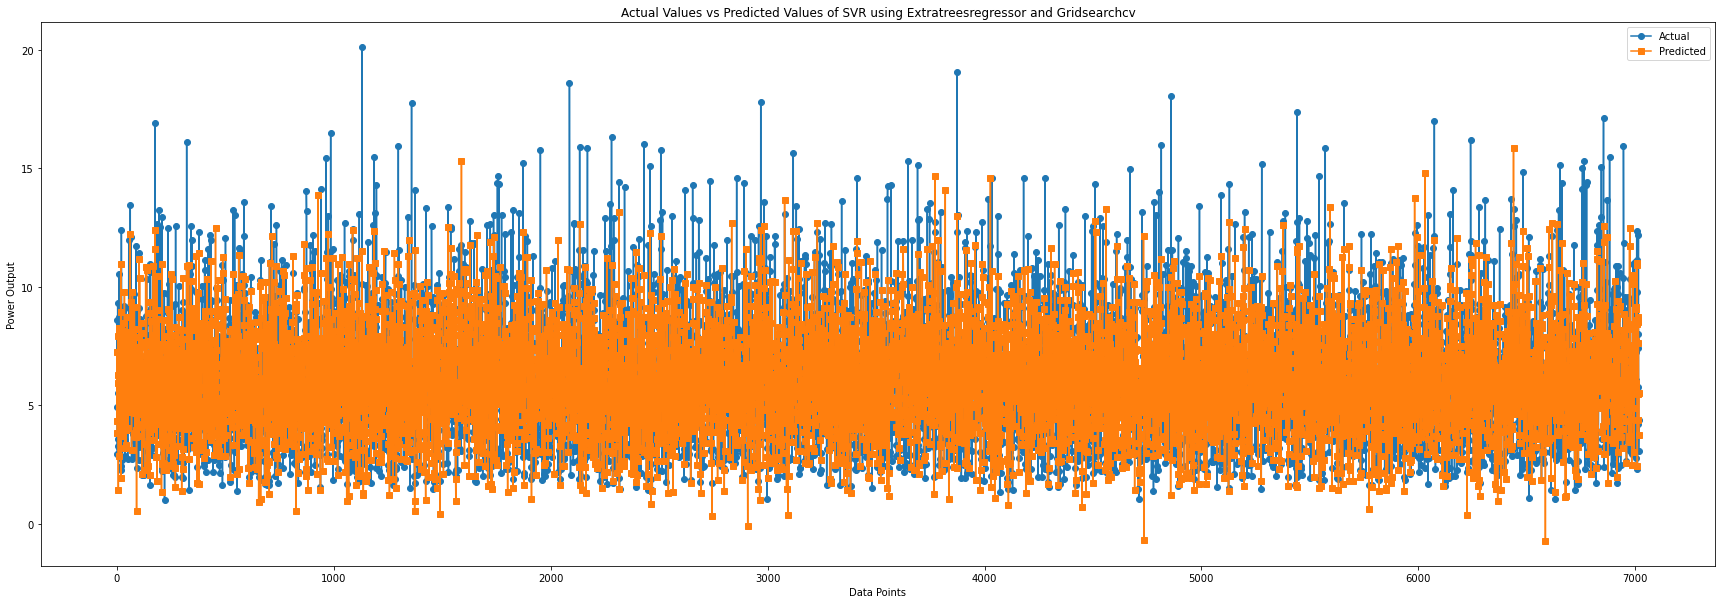

In [48]:
# Sort the actual and predicted values based on the data points
sorted_indices = range(len(y_test))
y_test_sorted = y_test.iloc[sorted_indices]
y_pred_sorted = tuned_pred[sorted_indices]

# Line plot with markers for actual and predicted values
plt.rcParams['figure.figsize'] = [30, 10]
plt.plot(sorted_indices, y_test_sorted, marker='o', label='Actual')
plt.plot(sorted_indices, y_pred_sorted, marker='s', label='Predicted')
plt.xlabel('Data Points')
plt.ylabel('Power Output')
plt.title('Actual Values vs Predicted Values of SVR using Extratreesregressor and Gridsearchcv')
plt.legend()
plt.show()

In [49]:
tuned_hyper_model.score(X_train,y_train)

0.7787381665921754

In [59]:
# With hyperparameter tuned 

from sklearn import metrics

print('MAE:', mean_absolute_error(y_test,tuned_pred))
print('MSE:', mean_squared_error(y_test, tuned_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, tuned_pred)))


MAE: 1.341212228569531
MSE: 3.198614451150802
RMSE: 1.788467067393415


In [60]:
from sklearn import metrics
# Without hyperparameter tuned 

print('MAE:', mean_absolute_error(y_test,prediction))
print('MSE:', mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(mean_squared_error(y_test, prediction)))

MAE: 1.3964631949597832
MSE: 3.4242831714107
RMSE: 1.850481875461281


### Testing the model

In [61]:
model = tuned_hyper_model.predict(test_data)

In [62]:
Ywrite=pd.DataFrame(model,columns=['windmill_generated_power(kW/h)'])
Ywrite.to_csv("Predictionsvr.csv",index=False)